In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_probability import distributions as tfd

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
from general_utilis import * # generate_dataset, visualise_data_points

In [5]:
# basic model, WTA, RWTA, disconected WTA
from models.encoders.resnet_18 import resnet_18
from models.heads.basic import * #basic_localisation_model, basic_localisation_model_disconected_graph
from models.decoders.fpn import resnet_fpn
from losses.mean_squared_error import *

In [6]:
# MDN model
from losses.mdn_loss import mdn_loss
from models.heads.mdn import mdn_model
from models.utilis.callbacks import * # GMM_Metrics, trace_max_component
from visualisations import *

# Generate Dataset

In [9]:
dataset_size = 1000
num_modes = 3
output_dim = 1
num_patterns = 10
noise = 0

images, labels, modes, pattern_ids = generate_dataset(dataset_size, num_modes, output_dim, num_patterns, noise)

## Visualise dataset - to check that evertyhing is correct

same pattern, different modes


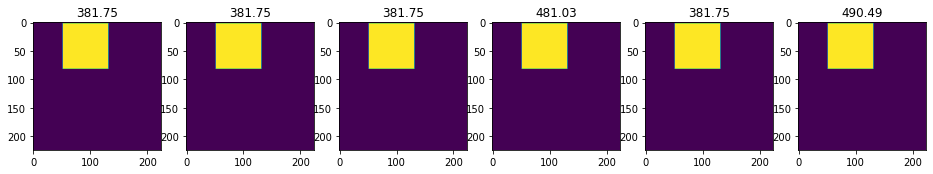

same pattern, same modes


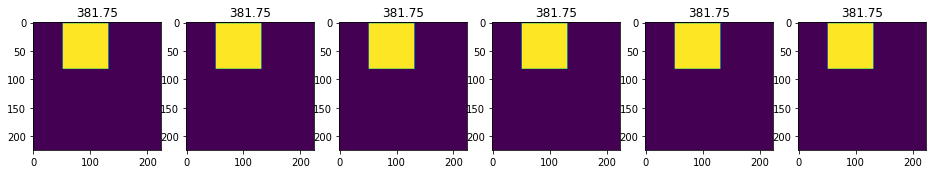

In [10]:
visualise_data_points(images, labels, modes, pattern_ids)

# Train, test split

In [11]:
train_size = 0.7
split = int(dataset_size * train_size)
x_train, x_test = images[:split], images[split:]
y_train, y_test = labels[:split], labels[split:]

In [12]:
modes_train, modes_test = modes[:split], modes[split:] 
pattern_ids_train, pattern_ids_test = pattern_ids[:split], pattern_ids[split:]

# Construct simple encoder-decoder network

### Encoder network

In [270]:
# get model
num_heads = 1
model = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss=multiple_heads_MSE(num_heads))

In [273]:
# fit with MSE
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 43ms/step - loss: 942.4219
Epoch 2/10
22/22 [==============================] - 1s 42ms/step - loss: 778.7093
Epoch 3/10
22/22 [==============================] - 1s 41ms/step - loss: 773.7058
Epoch 4/10
22/22 [==============================] - 1s 42ms/step - loss: 451.1288
Epoch 5/10
22/22 [==============================] - 1s 42ms/step - loss: 520.4225
Epoch 6/10
22/22 [==============================] - 1s 43ms/step - loss: 411.5976
Epoch 7/10
22/22 [==============================] - 1s 41ms/step - loss: 629.0049
Epoch 8/10
22/22 [==============================] - 1s 41ms/step - loss: 256.2217
Epoch 9/10
22/22 [==============================] - 1s 42ms/step - loss: 215.8119
Epoch 10/10
22/22 [==============================] - 1s 42ms/step - loss: 194.1711


### Visualise predictions

In [10]:
np.set_printoptions(suppress=True)

# visualise predictions
def print_predictions(model, x, y, num_heads):
    y_pred = model.predict(x)
    for gt, pred in zip(y, y_pred):
        min_error = 1e9
        for i in range(num_heads):
            min_error = min(min_error, np.round(np.mean(np.abs(gt-pred[i*3:(i+1)*3])),1))
        print('GT: ', np.round(gt,1), '   Pred: ', np.round(pred,1), '   Error: ', min_error)
        
# print_predictions(model, x_test[:10], y_test[:10], num_heads=1)

### Visualise performance on different modes for a single class

In [11]:
def print_error_per_mode(model, x, y, pattern_ids, modes, pattern_ID, num_modes, num_heads):
    pattern_indexes = np.where(pattern_ids == pattern_ID, 1, 0)
    
    for i in range(num_modes):
        mode_indexes = np.where(modes == i, 1, 0)
        mode_pat_indexes = pattern_indexes*mode_indexes
        mode_pat_indexes = mode_pat_indexes.astype(bool)

        x_tmp = x[mode_pat_indexes]
        y_tmp = y[mode_pat_indexes]
        y_pred = model.predict(x_tmp)
        
        print()
        for j in range(num_heads):
            mean_error = np.mean(np.abs(y_pred[:,j*3:(j+1)*3] - y_tmp))
            print(f'Head {j}, Mode {i} mean error: {np.round(mean_error, 2)}')
        print_predictions(model, x_tmp[:5], y_tmp[:5], num_heads)

# print_error_per_mode(model, x_test, y_test, pattern_ids_test, modes_test, 0, num_modes, num_heads=1)

<font color='red'>**I had to remove noise - but now atleast we clearly see that the NN learns to represent only one solution**</font>

# Train basic model - 3 MSE heads

In [120]:
# get model
num_heads = 3
model_3_heads = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads.compile(optimizer=adam, loss=multiple_heads_MSE(num_heads))

In [121]:
# fit with MSE
model_3_heads.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 51ms/step - loss: 111364.2734
Epoch 2/40
22/22 [==============================] - 1s 48ms/step - loss: 101474.5000
Epoch 3/40
22/22 [==============================] - 1s 48ms/step - loss: 86211.9766
Epoch 4/40
22/22 [==============================] - 1s 50ms/step - loss: 67118.6016
Epoch 5/40
22/22 [==============================] - 1s 49ms/step - loss: 47357.3359
Epoch 6/40
22/22 [==============================] - 1s 51ms/step - loss: 30688.4551
Epoch 7/40
22/22 [==============================] - 1s 48ms/step - loss: 20355.7949
Epoch 8/40
22/22 [==============================] - 1s 46ms/step - loss: 15673.2461
Epoch 9/40
22/22 [==============================] - 1s 46ms/step - loss: 14694.9453
Epoch 10/40
22/22 [==============================] - 1s 49ms/step - loss: 14525.5469
Epoch 11/40
22/22 [==============================] - 1s 49ms/step - loss: 14669.3389
Epoch 12/40
22/22 [==============================] - 1s 53ms/step - loss

In [132]:
print_error_per_mode(model_3_heads, x_test, y_test, pattern_ids_test, modes_test, 3, num_modes, num_heads)


Head 0, Mode 0 mean error: 18.02
Head 1, Mode 0 mean error: 17.87
Head 2, Mode 0 mean error: 17.96
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9

Head 0, Mode 1 mean error: 15.13
Head 1, Mode 1 mean error: 14.98
Head 2, Mode 1 mean error: 15.08
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  15.0
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  15.0
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0

<font color='red'>**As expected all 3 heads colapse to the same solution**</font>

# Train basic model - WTA loss function

In [150]:
# get model
num_heads = 3
model_3_heads_WTA = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads_WTA.compile(optimizer=adam, loss=multiple_heads_MSE_WTA(num_heads))

In [151]:
# fit with MSE
model_3_heads_WTA.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 60ms/step - loss: 36953.0898
Epoch 2/40
22/22 [==============================] - 1s 52ms/step - loss: 32951.7383
Epoch 3/40
22/22 [==============================] - 1s 58ms/step - loss: 26322.8828
Epoch 4/40
22/22 [==============================] - 1s 53ms/step - loss: 18376.6875
Epoch 5/40
22/22 [==============================] - 1s 55ms/step - loss: 11272.0029
Epoch 6/40
22/22 [==============================] - 1s 53ms/step - loss: 6660.7720
Epoch 7/40
22/22 [==============================] - 1s 50ms/step - loss: 5066.5312
Epoch 8/40
22/22 [==============================] - 1s 49ms/step - loss: 4825.9741
Epoch 9/40
22/22 [==============================] - 1s 48ms/step - loss: 4887.4448
Epoch 10/40
22/22 [==============================] - 1s 44ms/step - loss: 5174.6631
Epoch 11/40
22/22 [==============================] - 1s 46ms/step - loss: 4951.6509
Epoch 12/40
22/22 [==============================] - 1s 45ms/step - loss: 4947.2

In [153]:
print_error_per_mode(model_3_heads_WTA, x_test, y_test, pattern_ids_test, modes_test, 3, num_modes, num_heads)


Head 0, Mode 0 mean error: 26.49
Head 1, Mode 0 mean error: 73.22
Head 2, Mode 0 mean error: 72.9
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5

Head 0, Mode 1 mean error: 23.6
Head 1, Mode 1 mean error: 76.11
Head 2, Mode 1 mean error: 75.79
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  23.6
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  23.6
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1

<font color='red'>**Above we have an example of WTA problem**</font> Due to poor initalisation only one head gets updated at each batch itteration, because it has always the lowest error

# Train basic model - Relaxed-WTA loss function

https://arxiv.org/abs/1612.00197 - Learning in an Uncertain World: Representing Ambiguity Through Multiple Hypotheses

In [24]:
# get model
num_heads = 3
relaxation_weight = 0.001
model_3_heads_R_WTA = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

In [36]:
# compile
adam = keras.optimizers.Adam(0.0001)
model_3_heads_R_WTA.compile(optimizer=adam, loss=multiple_heads_MSE_Relaxed_WTA(num_heads, relaxation_weight))

In [37]:
# fit with MSE
model_3_heads_R_WTA.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 47ms/step - loss: 15310.1260
Epoch 2/10
22/22 [==============================] - 1s 44ms/step - loss: 15215.0010
Epoch 3/10
22/22 [==============================] - 1s 44ms/step - loss: 15420.9990
Epoch 4/10
22/22 [==============================] - 1s 45ms/step - loss: 15263.9141
Epoch 5/10
22/22 [==============================] - 1s 48ms/step - loss: 15378.4219: 0s - loss: 1
Epoch 6/10
22/22 [==============================] - 1s 46ms/step - loss: 15367.7139
Epoch 7/10
22/22 [==============================] - 1s 44ms/step - loss: 15560.7725
Epoch 8/10
22/22 [==============================] - 1s 45ms/step - loss: 15515.4600
Epoch 9/10
22/22 [==============================] - 1s 47ms/step - loss: 15201.9941
Epoch 10/10
22/22 [==============================] - 1s 46ms/step - loss: 15545.5645


In [35]:
print_error_per_mode(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test, modes_test, 1, num_modes, num_heads)


Head 0, Mode 0 mean error: 99.68
Head 1, Mode 0 mean error: 119.86
Head 2, Mode 0 mean error: 77.73
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7

Head 0, Mode 1 mean error: 43.87
Head 1, Mode 1 mean error: 23.56
Head 2, Mode 1 mean error: 65.62
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  23.6
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  23.6
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   

<font color='red'>**Heads do not colapse**</font> However, they don't cover each mode exactly. Heads' predictions lie somewhere in between modes. - not sure why this is the case. <font color='red'>**I may explore that case in more detail.**</font>

Things to try:
* see if your idea of disconecting gradients from seperate heads will work. i.e to make the main head learn the features of the trunk.

# Train basic model - disconected RWTA

In [183]:
# get model
num_heads = 3
relaxation_weight = 0.01
model_3_heads_RWTA_and_disconected = basic_localisation_model_disconected_graph(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads_RWTA_and_disconected.compile(optimizer=adam, loss=multiple_heads_MSE_Relaxed_WTA(num_heads, relaxation_weight))

In [184]:
# fit with MSE
model_3_heads_R_WTA.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 56ms/step - loss: 98410.6875
Epoch 2/40
22/22 [==============================] - 1s 56ms/step - loss: 89509.9453
Epoch 3/40
22/22 [==============================] - 1s 56ms/step - loss: 75127.7578: 1s - lo
Epoch 4/40
22/22 [==============================] - 1s 55ms/step - loss: 57383.6797
Epoch 5/40
22/22 [==============================] - 1s 49ms/step - loss: 39085.6758
Epoch 6/40
22/22 [==============================] - 1s 52ms/step - loss: 25048.3457
Epoch 7/40
22/22 [==============================] - 1s 51ms/step - loss: 16880.5527
Epoch 8/40
22/22 [==============================] - 1s 53ms/step - loss: 18644.9453
Epoch 9/40
22/22 [==============================] - 1s 51ms/step - loss: 17151.6016
Epoch 10/40
22/22 [==============================] - 1s 51ms/step - loss: 19208.7402
Epoch 11/40
22/22 [==============================] - 1s 57ms/step - loss: 18317.2422
Epoch 12/40
22/22 [==============================] - 1s 53ms/step

In [185]:
print_error_per_mode(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test, modes_test, 1, num_modes, num_heads)


Head 0, Mode 0 mean error: 41.35
Head 1, Mode 0 mean error: 1.38
Head 2, Mode 0 mean error: 28.01
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4

Head 0, Mode 1 mean error: 37.15
Head 1, Mode 1 mean error: 3.08
Head 2, Mode 1 mean error: 23.81
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  3.1
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  3.1
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6 

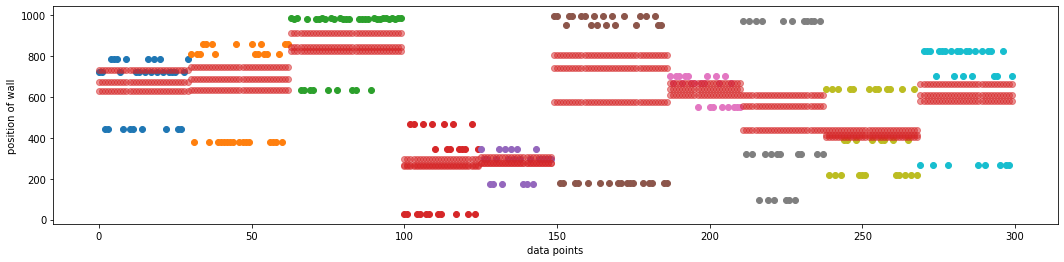

In [65]:
visualise_mode_overlap(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test)

**above shows how predicted modes overlap with actual modes**, we see that they don't overlap that well.
RED are predicted modes

# MDN - for 2D problem - 3 modes 3 mixtures

In [204]:
# get model
num_comp = 6
output_shape = 1
model_MDN = mdn_model(resnet_18, num_comp=num_comp, output_shape=output_shape, input_shape=(224,224,1))    

In [217]:
# compile
adam = keras.optimizers.Adam(0.0001)
model_MDN.compile(optimizer=adam, 
                  loss=mdn_loss(num_comp, output_shape=output_shape, fixed_variance=False), 
                  metrics=trace_max_component(num_comp, 10))

In [218]:
# train the model
# history = model_MDN.fit(x_train, y_train, batch_size=32, epochs=200)
history_var_on = model_MDN.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
22/22 [==============================] - 1s 48ms/step - loss: 23.2232 - max_mixture: 0.6392
Epoch 2/50
22/22 [==============================] - 1s 47ms/step - loss: 7.9694 - max_mixture: 0.7105
Epoch 3/50
22/22 [==============================] - 1s 48ms/step - loss: 7.1219 - max_mixture: 0.6963
Epoch 4/50
22/22 [==============================] - 1s 47ms/step - loss: 6.7361 - max_mixture: 0.7155
Epoch 5/50
22/22 [==============================] - 1s 48ms/step - loss: 6.6667 - max_mixture: 0.6888
Epoch 6/50
22/22 [==============================] - 1s 47ms/step - loss: 6.5456 - max_mixture: 0.7266
Epoch 7/50
22/22 [==============================] - 1s 48ms/step - loss: 6.4786 - max_mixture: 0.7062
Epoch 8/50
22/22 [==============================] - 1s 47ms/step - loss: 6.4518 - max_mixture: 0.6843
Epoch 9/50
22/22 [==============================] - 1s 47ms/step - loss: 6.3939 - max_mixture: 0.6933
Epoch 10/50
22/22 [==============================] - 1s 49ms/step - loss: 6.3670 

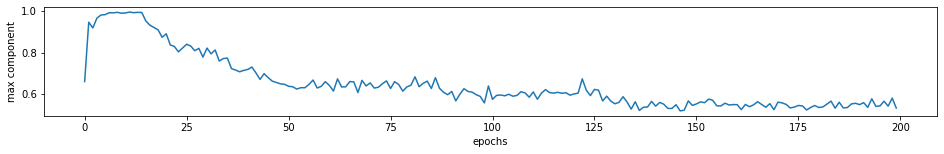

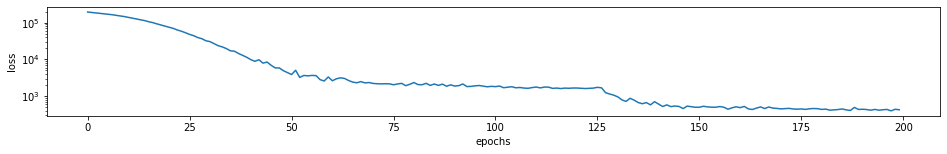

In [207]:
visualise_model_evolution(history.history['max_mixture'], 'max component')
visualise_model_evolution(history.history['loss'], 'loss', log=True)

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow_probability import distributions as tfd

def get_mixture_dist(logits, num_components, numpy=True):
    """
    This function converts logits into a categorical probability distribution
    there are 'num_components' elements in logits array. 
    Note: logits has to be 1D vector (i.e. you have to get categorical distribution for each datapoint seperately)  
    """
    dist = tfd.Categorical(logits=logits)
    n = 1e4
    empirical_prob = tf.cast(
        tf.histogram_fixed_width(
          dist.sample(int(n)),
          [0, num_components-1],
          nbins=num_components),
        dtype=tf.float32) / n
    if numpy:
        return empirical_prob.numpy()
    else:
        return empirical_prob



def visualise_probability_for_datapoint(model, x, y, pattern_ids, num_modes, pattern_ID=0, num_points=1, ind=None, fixed_variance=True):
    """
    This function visualises all modes ('y' values) for pattern associated with 'pattern_ID'.
    It will then plot the probability distribution outputed by the MDN. 
    """

    unique_patterns = np.unique(pattern_ids)
    p_indexes = np.where(pattern_ids == pattern_ID, 1, 0).astype(bool)
    gt_modes = np.unique(y[p_indexes])
    num_outputs = y.shape[-1]
    
    for i in range(num_points):
        plt.figure(figsize=(16,2))

        # plot probability
        y_tmp = y[p_indexes]
        x_tmp = x[p_indexes]
        if ind != None:
            random_ind = ind
        else:
            random_ind = np.random.randint(len(x_tmp))
        y_dist = model.predict(np.expand_dims(x_tmp[random_ind], axis=0))
        mix_comp, means, var = y_dist[0,:num_modes], y_dist[0,num_modes: (num_outputs+1)*num_modes], y_dist[0, (num_outputs+1)*num_modes:]
        if fixed_variance:
            var = [1]*num_modes
        
        # somehow need to plot a gaussian
        n = 1000
        y_samples = np.arange(n)
        probability = np.zeros(n)
        gaus_mix = get_mixture_dist(mix_comp, num_modes) 
        
        for j in range(num_modes):
            probability += gaus_mix[j] * norm.pdf(y_samples, loc=means[j], scale=var[j])
        plt.plot(y_samples, probability, linewidth=0.5, color='tab:blue', label='GMM\'s p(y|img)')
        
        # plot ground truth
        plt.scatter(y_tmp[random_ind], [0], color='tab:green', linewidth=10, alpha=0.5, label='sample GT')
        plt.scatter(gt_modes, [0] * len(gt_modes), linewidth=3, alpha=0.5, color='tab:red', label='GT modes')
        
        plt.ylabel('p( y | img)')
        plt.xlabel('y (distance)')
        plt.title(f'Pattern {pattern_ID}')
        plt.legend()
        plt.show()

        print(f'GT: {y_tmp[random_ind]}')
        for j in range(num_modes):
            pi = np.around(gaus_mix[j],2)
            mu = np.around(means[j],2)
            sig = np.around(var[j],2)
            print(f'Component {j+1}: pi=', pi, ', mu=', mu, ', sig=', sig)

            
def visualise_model_evolution(mix_evolution, y_label, log=False):
    """
    This function plots evolution of average max_mixture component across epochs.
    Because the dataset is balanced, each mode should receive approximately 0.33 component probability - so that should be the max
    However, in practice we are more likely to see max mixture with pi>0.33 because sometimesmodes overlap.
    
    It would be cool to see what happens when we use MDN with more mixtures then there are modes in the data.
    Maybe then this metric will be lower.
    """
    plt.figure(figsize=(16,2))
    plt.plot(range(len(mix_evolution)), mix_evolution)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    if log:
        plt.yscale('log')
    plt.show()            


def visualise_modes(model, x, y, pattern_ids, modes, num_modes, num_outputs):
    """
    This function shows where the predicted mode means lie with respect to the ground truth modes.
    later i may add a plot to visualise entire learned probability distribution.
    I use an arbitrary way to compute locations of modes (i.e. mean across all point sharing that mode.)
    This might be not the best way to do this. 
    It might be in fact best to evaluate this problem at a point-by-point basis. - see visualise_probability_for_datapoint() function
    """
    plt.figure(figsize=(16,2))
    unique_patterns = np.unique(pattern_ids)
    
    for i, p_id in enumerate(unique_patterns):
        p_indexes = np.where(pattern_ids == p_id, 1, 0)
        
        for m_id in range(num_modes):
            m_indexes = np.where(modes == m_id, 1, 0)
            mp_indexes = p_indexes * m_indexes
            mp_indexes = mp_indexes.astype(bool)

            x_tmp = x[mp_indexes]
            y_tmp = y[mp_indexes]
            y_pred = model.predict(x_tmp)
            
            main_comp_ind = np.argmax( np.mean(y_pred[:,:num_modes], axis=0) )
            means = np.mean(y_pred[:, num_modes:(1+num_outputs)*num_modes], axis=0 )
            plt.scatter(i, np.mean(y_tmp), color='tab:green')  # true
            plt.scatter(i, means[main_comp_ind], color='tab:orange')  # pred

    plt.show()

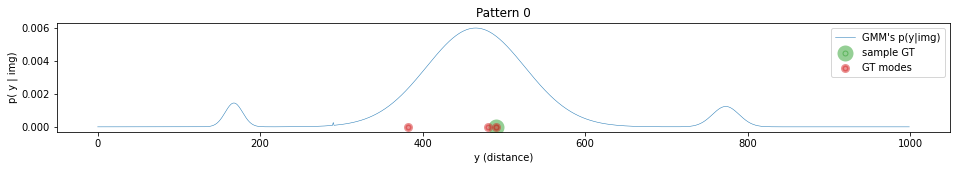

GT: [490.4910383]
Component 1: pi= 0.05 , mu= 773.1 , sig= 16.41
Component 2: pi= 0.04 , mu= 167.68 , sig= 10.78
Component 3: pi= 0.0 , mu= 375.29 , sig= 0.13
Component 4: pi= 0.0 , mu= 289.88 , sig= 0.19
Component 5: pi= 0.91 , mu= 465.24 , sig= 60.54
Component 6: pi= 0.0 , mu= 66.42 , sig= 213.17


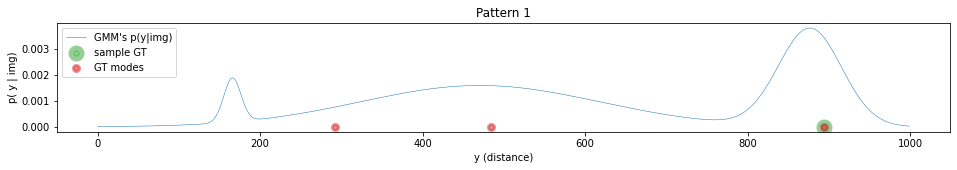

GT: [894.18601299]
Component 1: pi= 0.37 , mu= 876.67 , sig= 38.82
Component 2: pi= 0.04 , mu= 165.83 , sig= 10.54
Component 3: pi= 0.0 , mu= 396.87 , sig= 0.34
Component 4: pi= 0.0 , mu= 271.75 , sig= 0.01
Component 5: pi= 0.59 , mu= 470.39 , sig= 146.91
Component 6: pi= 0.0 , mu= 68.59 , sig= 109.0


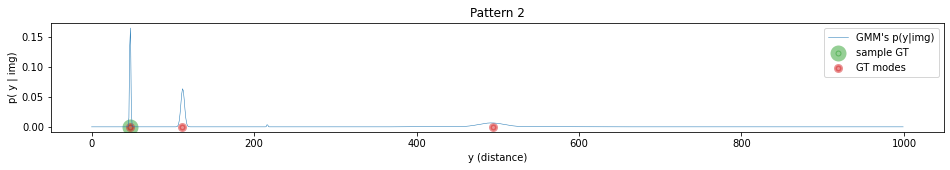

GT: [47.59360604]
Component 1: pi= 0.25 , mu= 492.17 , sig= 15.56
Component 2: pi= 0.36 , mu= 112.22 , sig= 2.23
Component 3: pi= 0.01 , mu= 216.4 , sig= 0.64
Component 4: pi= 0.03 , mu= 558.76 , sig= 41.26
Component 5: pi= 0.02 , mu= 417.65 , sig= 19.28
Component 6: pi= 0.34 , mu= 47.6 , sig= 0.71


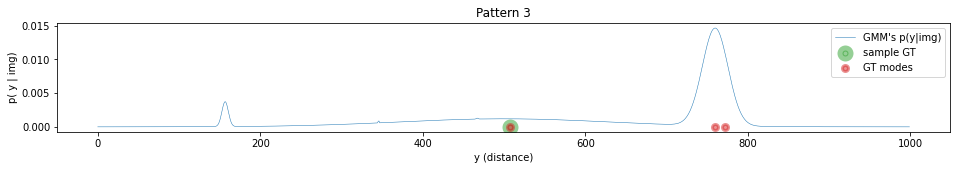

GT: [507.35128298]
Component 1: pi= 0.57 , mu= 759.89 , sig= 15.78
Component 2: pi= 0.04 , mu= 156.75 , sig= 3.95
Component 3: pi= 0.0 , mu= 345.59 , sig= 0.44
Component 4: pi= 0.0 , mu= 467.06 , sig= 1.17
Component 5: pi= 0.39 , mu= 500.07 , sig= 130.15
Component 6: pi= 0.0 , mu= 60.67 , sig= 12.26


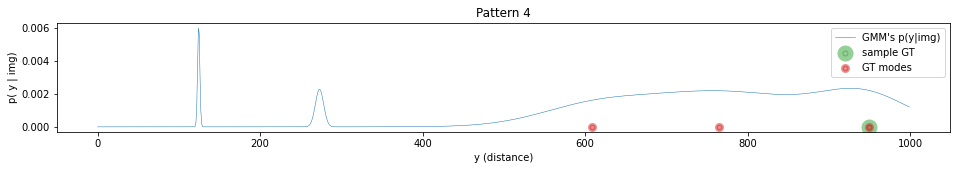

GT: [949.6829022]
Component 1: pi= 0.61 , mu= 764.75 , sig= 112.48
Component 2: pi= 0.02 , mu= 124.39 , sig= 1.36
Component 3: pi= 0.03 , mu= 273.08 , sig= 5.07
Component 4: pi= 0.22 , mu= 943.92 , sig= 52.8
Component 5: pi= 0.13 , mu= 603.24 , sig= 63.07
Component 6: pi= 0.0 , mu= 52.84 , sig= 0.01


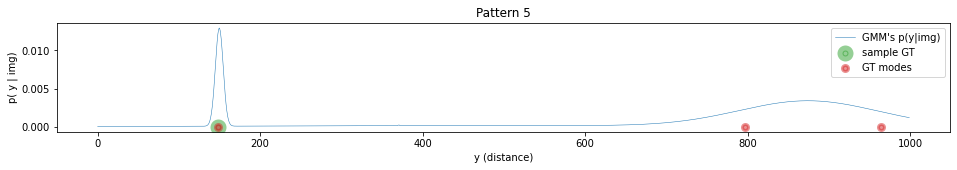

GT: [148.19040314]
Component 1: pi= 0.71 , mu= 874.82 , sig= 85.37
Component 2: pi= 0.16 , mu= 149.71 , sig= 4.82
Component 3: pi= 0.0 , mu= 370.66 , sig= 0.77
Component 4: pi= 0.0 , mu= 434.29 , sig= 0.07
Component 5: pi= 0.13 , mu= 503.71 , sig= 309.0
Component 6: pi= 0.0 , mu= 62.27 , sig= 8.81


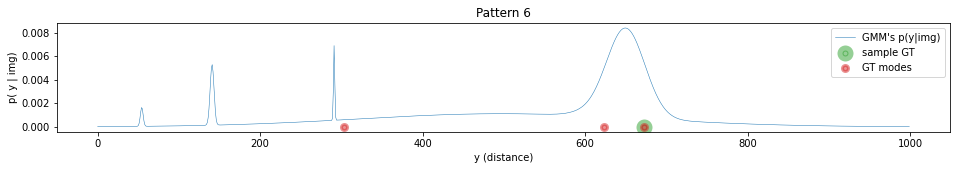

GT: [672.10076232]
Component 1: pi= 0.45 , mu= 649.73 , sig= 23.7
Component 2: pi= 0.03 , mu= 140.81 , sig= 2.36
Component 3: pi= 0.01 , mu= 291.07 , sig= 0.76
Component 4: pi= 0.01 , mu= 594.02 , sig= 16.98
Component 5: pi= 0.49 , mu= 496.91 , sig= 174.96
Component 6: pi= 0.01 , mu= 54.28 , sig= 1.7


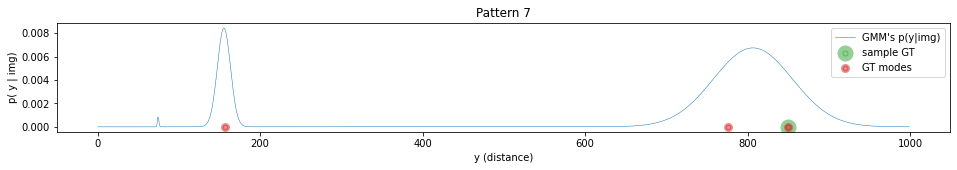

GT: [849.15310719]
Component 1: pi= 0.01 , mu= 533.62 , sig= 240.6
Component 2: pi= 0.0 , mu= 74.43 , sig= 0.84
Component 3: pi= 0.17 , mu= 155.41 , sig= 8.06
Component 4: pi= 0.82 , mu= 806.54 , sig= 48.6
Component 5: pi= 0.0 , mu= 448.51 , sig= 9.89
Component 6: pi= 0.0 , mu= 37.09 , sig= 0.01


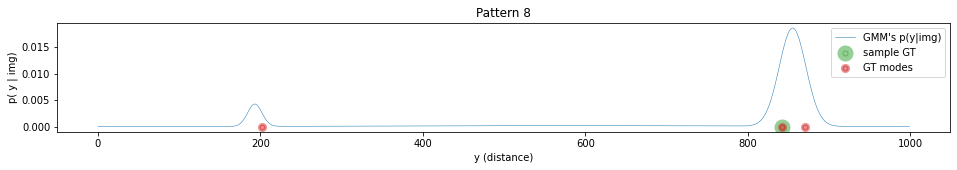

GT: [842.36722004]
Component 1: pi= 0.76 , mu= 855.22 , sig= 16.41
Component 2: pi= 0.09 , mu= 193.23 , sig= 8.87
Component 3: pi= 0.0 , mu= 408.67 , sig= 0.14
Component 4: pi= 0.0 , mu= 426.11 , sig= 0.67
Component 5: pi= 0.15 , mu= 548.71 , sig= 252.58
Component 6: pi= 0.0 , mu= 72.95 , sig= 136.85


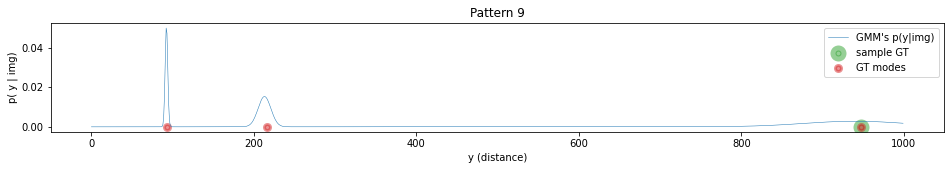

GT: [946.71807486]
Component 1: pi= 0.05 , mu= 665.68 , sig= 327.37
Component 2: pi= 0.2 , mu= 92.37 , sig= 1.58
Component 3: pi= 0.3 , mu= 213.03 , sig= 7.85
Component 4: pi= 0.44 , mu= 939.94 , sig= 62.6
Component 5: pi= 0.0 , mu= 541.37 , sig= 22.38
Component 6: pi= 0.0 , mu= 43.47 , sig= 0.0


In [221]:
ind = np.random.randint(50)
pattern_ID = 0
for i in range(10):
    pattern_ID = i
    visualise_probability_for_datapoint(model_MDN, x_train, y_train, pattern_ids_train, num_comp, pattern_ID=pattern_ID, num_points=1, ind=ind, fixed_variance=False)

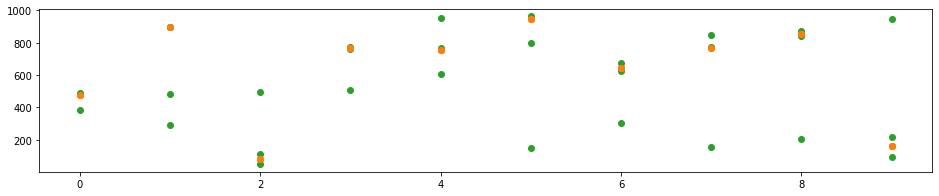

In [125]:
visualise_modes(model_MDN, x_train, y_train, pattern_ids_train, modes_train, num_modes, 1)

In [35]:
# need a function that can visualise predictions of the MDN model
def get_mode_means_for_X_COORD(model, x, y, num_comp, output_shape, compare):
    y_dist = model.predict(x)
    
    gaus_comp = y_dist[:,:num_comp]
    means = y_dist[:,num_comp:(output_shape+1)*num_comp]
    variances = y_dist[:,(output_shape+1)*num_comp:]
    
    mode_mean = np.zeros((y_dist.shape[0]))
    for j in range(len(x)):
        if num_comp >1:
            mixture_dist = get_mixture_dist(gaus_comp[j,:], num_comp) 
        else:
            mixture_dist = 1
        means_x = means[j,:]
        mode_mean[j] = np.dot(mixture_dist, means_x)

        print(f'GT: {np.round(y[j],2)}') #',   Pred: {np.round(mode_mean[j], 2)}')
#         print(f'lower bound:  {np.round(mode_mean[j]-mode_var[j],2)},   upper bound: {np.round(mode_mean[j]+mode_var[j],2)}')
        print(f'prd mix components: {mixture_dist}')
        print(f'prd means: {means[j]}')
        print(f'pred var: {variances[j]}')
        print()
    
    return mode_mean


In [54]:
mode_means = get_mode_means_for_X_COORD(model_MDN, x_train[:10], y_train[:10], num_comp, 1, compare=True)

GT: [496.16]
prd mix components: [0.002  0.0205 0.9775]
prd means: [233.71793 136.84425 497.46725]
pred var: [23.94206  32.394592  4.76361 ]

GT: [60.11]
prd mix components: [0.9986 0.0008 0.0006]
prd means: [ 64.206566 194.5998   643.497   ]
pred var: [ 2.6513455 46.784756  28.183924 ]

GT: [149.96]
prd mix components: [0.0005 0.9977 0.0018]
prd means: [508.4638  150.71896 664.147  ]
pred var: [22.011208   3.5202203 17.73889  ]

GT: [241.25]
prd mix components: [0.0085 0.9182 0.0733]
prd means: [188.9023  242.64659 732.829  ]
pred var: [28.570454   3.9311595  9.307612 ]

GT: [918.71]
prd mix components: [0.6315 0.0003 0.3682]
prd means: [916.9691  157.35204 874.6677 ]
pred var: [ 8.49213    3.2332115 11.04581  ]

GT: [496.16]
prd mix components: [0.0002 0.0084 0.9914]
prd means: [278.00772 133.24611 499.0411 ]
pred var: [26.940407 26.004368  4.311767]

GT: [864.6]
prd mix components: [0.3517 0.001  0.6473]
prd means: [905.60474 157.55096 860.71094]
pred var: [8.627409  3.2006042 9.287

In [ ]:
def get_predictions_MDN(model, x):
    y_dist = model.predict(x)
    
    gaus_comp = y_dist[:,:num_comp]
    means = y_dist[:,num_comp:(output_shape+1)*num_comp]
    variances = y_dist[:,(output_shape+1)*num_comp:]
    
#     mode_mean = np.zeros(len(x))
    mixture_dist = np.zeros((len(x), 3))
    
    for j in range(len(x)):
#         if num_comp >1:
        mixture_dist[j] = get_mixture_dist(gaus_comp[j,:], num_comp) 
#         else:
#             mixture_dist = 1
#         means_x = means[j,:]
#         mode_mean[j] = np.dot(mixture_dist, means_x)
        
    mix, mean, var = mixture_dist, means, variances
    return mix, mean, var

def print_error_per_mode_MDN(model, x, y, pattern_ids, modes, pattern_ID, num_modes, num_heads):
       
    pattern_indexes = np.where(pattern_ids == pattern_ID, 1, 0)
    
    for i in range(num_modes):
        mode_indexes = np.where(modes == i, 1, 0)
        mode_pat_indexes = pattern_indexes*mode_indexes
        mode_pat_indexes = mode_pat_indexes.astype(bool)

        x_tmp = x[mode_pat_indexes]
        y_tmp = y[mode_pat_indexes]
        mix, mean, var = get_predictions_MDN(model, x_tmp)
        
        print(f'MODE: {i}')
        for j in range(5):
            print(f'GT: {np.round(y_tmp[j],2)},  mix: {np.round(mix[j],2)},   means: {np.round(mean[j],2)},   var: {np.round(var[j],2)}')
        print()
        

print_error_per_mode_MDN(model_MDN, x_train, y_train, pattern_ids_train, modes_train, 0, num_modes, num_heads=1)